# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. Each worth 15 points.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### (15pt) Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
def Q1(num_examples=5):
    ### STUDENT START ###
    for x, y in enumerate(train_data[0:num_examples]):
        print("*********Label of Message " + str(x) + ": " +  str(categories[train_labels[x]]) + "*********") 
        print("_____Text of Message " + str(x) + ":" + "_____" + " \n")
        print(y)
    ### STUDENT END ###

Q1(5)

*********Label of Message 0: talk.religion.misc*********
_____Text of Message 0:_____ 

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
*********Label of Message 1: sci.space*********
_____Text of Message 1:_____ 



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones

### (15pt) Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [4]:
def Q2():
    ### STUDENT START ###
    vectorizer = CountVectorizer()
    vectorized_train_d = vectorizer.fit_transform(train_data)
    
    print("----------------Part_1-------------------")
    #size of the vocabulary
    vocabulary_size = vectorized_train_d.shape[1]
    #average number of non-zero features per example
    average_non_zero_feature_per_example = vectorized_train_d.nnz/vectorized_train_d.shape[0]
    #fraction of non zero entries in matrix
    fraction_of_non_zero_entries = float(vectorized_train_d.nnz)/(vectorized_train_d.shape[0]*vectorized_train_d.shape[1])
    #zero'th and last feature strings in alphabetical order
    zero_last_string = [vectorizer.get_feature_names()[rank] for rank in [0,-1]]
    
    print ("Vocabulary size (unigram): {vs}".format(vs=vocabulary_size))
    print ("Average number of non-zero features per example: {nz}".format(nz=round(average_non_zero_feature_per_example,2)))
    print ("Fraction of non-zero entries: {fnz}".format(fnz=round(fraction_of_non_zero_entries,4)))
    print ("The first string is {first_s} and the last string is {last_s}"
           .format(first_s=zero_last_string[0],last_s=zero_last_string[1]))
    print('')
    
    print("----------------Part_2-------------------")
    vectorizer_four_words = CountVectorizer(vocabulary= ["atheism", "graphics", "space", "religion"])      
    vectorizer_four_words_train = vectorizer_four_words.fit_transform(train_data)
    
    four_word_vocabulary_size = vectorizer_four_words_train.shape[1]
    four_word_average_non_zero_feature_per_example = vectorizer_four_words_train.nnz/vectorizer_four_words_train.shape[0]
    print ("Vocabulary size for four words : {vs}".format(vs=four_word_vocabulary_size))
    print ("Four words average number of non-zero features per example: {nz}"
           .format(nz=round(four_word_average_non_zero_feature_per_example,2)))
    print('')
    
    print("----------------Part_3-------------------")
    vectorizer_bigram_and_trigram = CountVectorizer(analyzer="char",ngram_range=(2,3))    
    vectorizer_bigram_and_trigram_train = vectorizer_bigram_and_trigram.fit_transform(train_data)
    vocabulary_bigram_and_trigram_size = vectorizer_bigram_and_trigram_train.shape[1]
    print("Vocabulary size (bigram, trigram): {v}".format(v=vocabulary_bigram_and_trigram_size))
    print('')
    
    print("----------------Part_4-------------------")
    vectorizer_fewer_than_10 = CountVectorizer(min_df=10)    
    vectorizer_fewer_than_10_train = vectorizer_fewer_than_10.fit_transform(train_data)
    vocabulary_fewer_than_10_size = vectorizer_fewer_than_10_train.shape[1]
    print("Vocabulary size (words that occur in at least 10 documents): {v10}".format(v10=vocabulary_fewer_than_10_size))
    print('')
    
    print("----------------Part_5-------------------")
    vectorizer_dev =  CountVectorizer()
    vectorized_dev = vectorizer_dev.fit_transform(dev_data)
    vocabulary_size_dev = vectorized_dev.shape[1]
    vocab_in_dev_not_in_train = set(vectorizer_dev.get_feature_names()).difference(vectorizer.get_feature_names())
    fraction_missing_dev = len(vocab_in_dev_not_in_train)/vocabulary_size_dev
    print("{f}% of words in the development vocabulary is missing from the training vocabulary.".
          format(f=round(fraction_missing_dev*100,2)))
    
           
    
    ### STUDENT END ###

Q2()

----------------Part_1-------------------
Vocabulary size (unigram): 26879
Average number of non-zero features per example: 96.71
Fraction of non-zero entries: 0.0036
The first string is 00 and the last string is zyxel

----------------Part_2-------------------
Vocabulary size for four words : 4
Four words average number of non-zero features per example: 0.27

----------------Part_3-------------------
Vocabulary size (bigram, trigram): 35478

----------------Part_4-------------------
Vocabulary size (words that occur in at least 10 documents): 3064

----------------Part_5-------------------
24.79% of words in the development vocabulary is missing from the training vocabulary.


### (15pt) Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def Q3():
    ### STUDENT START ###
    vectorizer=CountVectorizer()
    X=vectorizer.fit_transform(train_data)
    Y=vectorizer.transform(dev_data)
    
    print("=========================KNN Classifier=========================")
    #trying KNN with different k values
    k_values=[1,3,5,7,9,11,13,15,17,19,21]
    for k in k_values:
        model_knn=KNeighborsClassifier(n_neighbors=k)
        model_knn.fit(X,train_labels)
        print("KNN Classifier with k =",k)
        print("F1-score =",metrics.f1_score(dev_labels,model_knn.predict(Y),average="weighted"))
        print("")
    print("k = 7 OPTIMIZES f1_SCORE")
    print("")
        
        
    print("=========================Mutlinomial NB=========================")
    #trying Multinomial NB with different alphas. 
    alpha=list(range(10))
    for a in alpha:
        model_NB=MultinomialNB(alpha=a)
        model_NB.fit(X,train_labels)
        print("Multinomial NB Classifier with alpha =",a)
        print("F1-score =",metrics.f1_score(dev_labels,model_NB.predict(Y),average="weighted"))
        print("")
    print("alpha = 7 OPTIMIZES f1_SCORE")
    print("")
        
        
    print("=========================Logistic Regression=========================")
    C_list=[0.001, 0.01, 0.1, 0.20, 0.30, 0.50, 1, 10, 25, 50, 100, 1000]
   
    for C in C_list:
        model_LR=LogisticRegression(C=C,solver="liblinear", multi_class="auto")
        model_LR.fit(X,train_labels)
        print("Logistic Regression Classifier with C =",C)
        print("F1-score =",metrics.f1_score(dev_labels,model_LR.predict(Y),average='weighted'))
        sum_of_squared_weights=list(map(sum,list(map(lambda x:x**2,model_LR.coef_))))
        print("Sum of squared weights from Logistic Regression model:",sum_of_squared_weights)
    print("C = 0.3 OPTIMIZES f1_SCORE")

    ### STUDENT END ###

Q3()

=========================KNN Classifier=========================
KNN Classifier with k = 1
F1-score = 0.3805030018531525

KNN Classifier with k = 3
F1-score = 0.4084150225437623

KNN Classifier with k = 5
F1-score = 0.4287607236218357

KNN Classifier with k = 7
F1-score = 0.45047910006117586

KNN Classifier with k = 9
F1-score = 0.4365666176198027

KNN Classifier with k = 11
F1-score = 0.4266108018696209

KNN Classifier with k = 13
F1-score = 0.42404338833763805

KNN Classifier with k = 15
F1-score = 0.4326339805547054

KNN Classifier with k = 17
F1-score = 0.4485853212909305

KNN Classifier with k = 19
F1-score = 0.4365794782510113

KNN Classifier with k = 21
F1-score = 0.42609394906353587

k = 7 OPTIMIZES f1_SCORE

=========================Mutlinomial NB=========================
Multinomial NB Classifier with alpha = 0
F1-score = 0.747240657284563

Multinomial NB Classifier with alpha = 1
F1-score = 0.7777320236017224

Multinomial NB Classifier with alpha = 2
F1-score = 0.76899664723

ANSWER (Part.5):\
KNN model compares each test value to training value and predicts according to the most similar training example based on distance. In our case, most words will not be very indicative and our model uses Euclidean distance. Since we have a high number of features, our model might suffer for curse of dimentionality. We might be able to resolve this issue, if more importance is given to specific sets of features.  


ANSWER (Part.6): \
`Naive Bayes` assumes all features are independent. In this case,the reason `Naive Bayes` is outperforming `Logistic Regression` could be due to a small size of data. As we increase the size of our data, it is very likely that `Logistic Regression` will give us better predictions. 

ANSWER (Part.7):\
As we can above, as we increase `C value`, the sum of squared weights increases as well. `C value` is the inverse of regularization strenght, which explains higher regularization values (smaller `C values`).  

### (15pt) Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [6]:
def Q4():
    ### STUDENT START ###
    
    print("===========================bigram features=========================")
    #transforming data to a matrix of bigram feature vectors
    vectorizer=CountVectorizer(ngram_range=(2,2))
    X=vectorizer.fit_transform(train_data)
    Y=vectorizer.transform(dev_data)
    vocabulary=np.array(vectorizer.get_feature_names())
    
    #building model
    model = LogisticRegression(C=0.5,solver="liblinear", multi_class="auto")
    model.fit(X, train_labels)
    indices_all = np.zeros(20, dtype = int) # creating an array of 20 zeroes
    for n in range(len(newsgroups_train.target_names)):
        coef = model.coef_[n,] #getting weights for each topic
        coef_array = np.array(coef) #changing it to an array
        
        indices = coef_array.argsort()[-5:][::-1] #getting indices sorted by element value
        indices_all[n*5:(n+1)*5] = indices
        
        #printing top features in each topic
        print("Top Features for class %s:"%newsgroups_train.target_names[n]) 
        print(vocabulary[indices])

    index = vocabulary[indices_all]
    dic = {} #creating an empty dictionary 
    for i in range(len(newsgroups_train.target_names)):
        dic[newsgroups_train.target_names[i]] = model.coef_[i, indices_all] #mapping features based on above
    datatable = pd.DataFrame(data = dic, index= index) #converting dictionary to dataFrame
    print(datatable)
        
        
    ### STUDENT END ###

Q4()

===========================bigram features=========================
Top Features for class alt.atheism:
['claim that' 'cheers kent' 'was just' 'you are' 'are you']
Top Features for class comp.graphics:
['looking for' 'in advance' 'comp graphics' 'out there' 'is there']
Top Features for class sci.space:
['the space' 'the moon' 'sci space' 'and such' 'it was']
Top Features for class talk.religion.misc:
['the fbi' 'cheers kent' 'ignorance is' 'but he' 'of jesus']
               alt.atheism  comp.graphics  sci.space  talk.religion.misc
claim that        0.605549      -0.199040  -0.274341           -0.140365
cheers kent       0.555719      -0.697905  -0.663759            0.534812
was just          0.482050      -0.131420  -0.128909           -0.227463
you are           0.472741      -0.279907  -0.481309            0.028381
are you           0.446954      -0.248256  -0.097131           -0.305616
looking for      -0.630341       1.108370  -0.499983           -0.571856
in advance       -0.4593

ANSWER: `cheers kent` is a top feature for two topics; `alt.atheist` and `talk.religion.misc`. Also, a lot of strongest features are "stop words" such `you are`, `are you`, `is there`, `it was`, etc. 

### (15pt) Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [7]:
from sklearn.metrics import f1_score

#creating a function with no preprocessing
def no_preprocessor(text):
    return text

#creating a function with actual preprocessing
def actual_preprocessor(text):
    text = text.lower() #lower case
    text = re.sub('[^A-Za-z0-9]', ' ', text) #remove non alpha numeric characters
    text = re.sub('[/\r?\n|\r/]', ' ', text) #remove line breaks
    text = re.sub("(\w{7})\w+", "\\1", text) #shorten long words
    text = re.sub('([0-9]+)', '#', text) #numbers
    return text

def Q5():
### STUDENT START ###   

    #getting vocabulary size, training model, and f1 score
    def get_f1(func):
        
        vectorizer = CountVectorizer(preprocessor=func)
        X = vectorizer.fit_transform(train_data)
        Y = vectorizer.transform(dev_data)
        model_lr = LogisticRegression()
        model_lr.fit(X, train_labels)
        model_lr_predict = model_lr.predict(Y)
        f1 = metrics.f1_score(dev_labels,model_lr_predict,average='weighted')
        print("Vocabulary size: {feature}".format(feature=X.shape[1]))
        print("f1-score: {f}".format(f=f1))
        return [X.shape[1],f1]
    
    print('Empty preprocessor:\n')
    no_process = get_f1(no_preprocessor)
    
    print('\nBetter preprocessor:\n')
    actual_process = get_f1(actual_preprocessor)
    
    print('\nVocabulary size has decreased by {value}.'.format(value=no_process[0]-actual_process[0]))
    print('\nF1-score has increased by {cc}.'.format(cc=actual_process[1]-no_process[1]))

### STUDENT END ###    
Q5()  

Empty preprocessor:

Vocabulary size: 33291
f1-score: 0.6848049102795098

Better preprocessor:

Vocabulary size: 19730
f1-score: 0.7041753961036631

Vocabulary size has decreased by 13561.

F1-score has increased by 0.01937048582415324.


### (15pt) Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

Logistic Regression with L1-penalty with C = 0.01
F1-score = 0.3965989944396829
Vocabulary size: 26879
Logistic Regression with L2-penalty and non-zeros with C = 0.01
F1-score = 0.4360540130277036
Vocabulary size: 17
Logistic Regression with L1-penalty with C = 0.025
F1-score = 0.481408926302057
Vocabulary size: 26879
Logistic Regression with L2-penalty and non-zeros with C = 0.025
F1-score = 0.5458674596774568
Vocabulary size: 52
Logistic Regression with L1-penalty with C = 0.05
F1-score = 0.5592009901083075
Vocabulary size: 26879
Logistic Regression with L2-penalty and non-zeros with C = 0.05
F1-score = 0.5956090185574183
Vocabulary size: 122
Logistic Regression with L1-penalty with C = 0.1
F1-score = 0.6319289380022638
Vocabulary size: 26879
Logistic Regression with L2-penalty and non-zeros with C = 0.1
F1-score = 0.658144517765182
Vocabulary size: 211
Logistic Regression with L1-penalty with C = 0.25
F1-score = 0.6813617392930976
Vocabulary size: 26879
Logistic Regression with L2-p

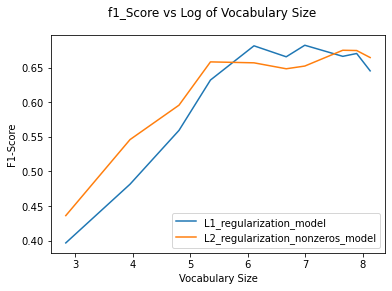

In [8]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    Y = vectorizer.transform(dev_data)
    vocabulary = np.array(vectorizer.get_feature_names())
    
    vocabulary_count = [] #creating an empty list

    d={'L1':[],'reduced_L2':[]} #creating two emtpy lists
    C_list=[0.01, .025, .05, 0.1, 0.25, 0.5, 1, 2.5, 5, 10] #list of c values
    
        
    #----------------Running A LR with l1 regularization-----------------------
    for c in C_list:
        model=LogisticRegression(penalty='l1',C=c,tol=.015,solver="liblinear")
        model.fit(X,train_labels)
        print("Logistic Regression with L1-penalty with C =",c)
        print("F1-score =",metrics.f1_score(dev_labels,model.predict(Y),average='macro'))
        print("Vocabulary size: {sss}".format(sss=X.shape[1]))
        
        #grabbing zeros
        non_zeros=np.sum(model.coef_!=0,axis=0)!=0
        reduced_vocab=vocabulary[non_zeros]
    
        #appending non_zeros to the vocabulary_count list
        vocabulary_count.append(np.sum(non_zeros))
        #appending f1 scores to L1 list
        d['L1'].append(metrics.f1_score(dev_labels,model.predict(Y),average='macro'))
        
    
    #---------------Running A LR with L2 regularization with non-zeros-------------
        
        #Note: the question says to put C value as 0.5, I used a list of C valuesto get a better understanding. 
        
        model=LogisticRegression(penalty='l2',C=c,tol=.015,solver="liblinear")
        model.fit(X[:,non_zeros],train_labels)
        print("Logistic Regression with L2-penalty and non-zeros with C =",c)
        print("F1-score =",metrics.f1_score(dev_labels,model.predict(Y[:,non_zeros]),average='macro'))
        print("Vocabulary size: {ggg}".format(ggg=X[:,non_zeros].shape[1]))
        #appending values to reduced_L2 list
        d['reduced_L2'].append(metrics.f1_score(dev_labels,model.predict(Y[:,non_zeros]),average='macro'))
    
    #taking the log of vocabulary count
    vocabulary_count_log = [math.log(x) for x in vocabulary_count]
    
    plt.plot(vocabulary_count_log,d['L1'], label = "L1_regularization_model")
    plt.plot(vocabulary_count_log,d['reduced_L2'], label = "L2_regularization_nonzeros_model")
    plt.suptitle('f1_Score vs Log of Vocabulary Size')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('F1-Score')
    plt.legend()
    
    ### STUDENT END ###

Q6()

ANSWER: For lower `C values`, it looks like the model with reduced vocabulary performs better. However, as we increase the `C value`, the vocabulary size for L2_regularization Model with nonzeros steadily increases. Furthermore,  as `C value` increases, both models seem to peform very similar.

### (15pt) Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def Q7():
    ### STUDENT START ###
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(train_data)
    Y = vectorizer.transform(dev_data)
    
    #building Model
    model_t=LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    model_t.fit(X,train_labels)
    print("F1-score =",metrics.f1_score(dev_labels,model_t.predict(Y),average='macro'))
    
    pred = model_t.predict(Y)
    prob = model_t.predict_proba(Y)
    
    R_values=np.array([prob[i,pred[i]]/prob[i,dev_labels[i]] for i in range(len(dev_labels))])
    indices=R_values.argsort()[-3:][::-1]
    
    for n in indices:
        print("Correct Label:",newsgroups_train.target_names[dev_labels[n]])
        print("Predicted Label:",newsgroups_train.target_names[pred[n]])
        print("R-value:",R_values[n])
        print("")
        print(dev_data[n])
        print("")

    ### STUDENT END ###

Q7()

F1-score = 0.7473913101645842
Correct Label: talk.religion.misc
Predicted Label: comp.graphics
R-value: 929.3575792165549

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way

ANSWER:

CountVectorizer counts word frequencies, while in TfidfVectorizer, the value increases proportionally to the count. It is, however, offset by frequency in the dictionary. The first document was predicted wrongly because perhaps there are ASCI, LateX, etc words that are generalyy associated with computer graphics.\

The second document is very short and it contains the words email and internet which are generally associated with computer graphics. This may have the compter to predict wrongly.R-squared as described by the question is the maximum predicted probability over the predicted probablity of the label. 

Anyhow, a possible solution would be to remove features from the vocabulary that are commone in specific topics. For example, atheism and talk.relgion.misc. Furthmore, we can preprocess "stop words" to possible improve our classifications. 


A possible solution might be to remove features/words from our vocabulary that are common in both atheism and talk.religion.misc, as well as other highly misclassifed topic combinations that we can identify from the confusion matrix. We can also try to perform preprocessing and common stop words in order to better improve the overall classification.

### (15pt) Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.